In [1]:
### First we handle our files ###
BASE_PATH = "../data"
FILE = "294_737_599"
tree_path = f"{BASE_PATH}/{FILE}.tree"
alignment_path = f"{BASE_PATH}/{FILE}.fas.alg"
table_path = f"{BASE_PATH}/{FILE}.tsv"
uniprot_path = f"../uniprot_2018_09.json"

### And we store them in different variables ###
try:
    with open(table_path, "r") as table_file:
        table_info = table_file.readlines()
    table_file.close()
except:
    print ("No table path.")
        
try:
    with open(alignment_path, "r") as alignment_file:
        alignment_info = alignment_file.read()
    alignment_file.close()
except:     
    print ("No alignment path.")
        
import json
uniprot_info = {}
with open(uniprot_path, "r") as uniprot_file:
    for line in uniprot_file:
        uniprot_entry = json.loads(line)
        uniprot_info.update(uniprot_entry)
    uniprot_file.close

In [2]:
### LOADING THE SPECIFIED TAG INFORMATION FROM OUR ALIGNMENT ###
def retrieve_features (feature_tag, table_file):
    uniprot_hit_hash = {}
    for line in table_file:
        hit_type = line.split("\t")[2]
        hit_name = line.split("\t")[3]
        if (hit_type == ("spb" or "spe") and hit_name not in uniprot_hit_hash):
            features_newlist = []
#             for feature in uniprot_info[hit_name]["FT"]: # TO CHECK FEATURES WHEN WE PICK A NEW FILE MANUALLY
#                 print (feature)
            for feature in uniprot_info[hit_name]["FT"]:
                if feature["ft"] == feature_tag:
                    features_newlist.append(feature)
            if len(features_newlist) > 0:
                uniprot_hit_hash[hit_name] = features_newlist
    return uniprot_hit_hash

In [3]:
uniprot_hit_hash = retrieve_features("BINDING", table_info)
print (uniprot_hit_hash)

{'A3CL77': [{'ft': 'BINDING', 's': '109', 'e': '109', 'ann': 'Substrate. {ECO:0000255|HAMAP-Rule:MF_00087}.'}, {'ft': 'BINDING', 's': '120', 'e': '120', 'ann': 'Substrate. {ECO:0000255|HAMAP-Rule:MF_00087}.'}], 'Q88E10': [{'ft': 'BINDING', 's': '138', 'e': '138', 'ann': 'Acetate. {ECO:0000269|PubMed:23112148}.'}, {'ft': 'BINDING', 's': '183', 'e': '183', 'ann': 'Acetate. {ECO:0000269|PubMed:23112148}.'}, {'ft': 'BINDING', 's': '187', 'e': '187', 'ann': 'Acetate. {ECO:0000269|PubMed:23112148}.'}, {'ft': 'BINDING', 's': '236', 'e': '236', 'ann': 'Acetate. {ECO:0000269|PubMed:23112148}.'}, {'ft': 'BINDING', 's': '254', 'e': '254', 'ann': 'Malate/succinate.{ECO:0000269|PubMed:23112148}.'}, {'ft': 'BINDING', 's': '258', 'e': '258', 'ann': 'Malate. {ECO:0000269|PubMed:23112148}.'}]}


In [4]:
### LOADING THE TREE WITH ETE3 ###    
from ete3 import PhyloTree, TreeStyle, SeqMotifFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

In [5]:
### TRANSFORMING THE SEQUENCE POSITIONS INTO ALIGNMENTS POSITIONS ###
def get_alignment_position (sequence_position, sequence):
    alignment_position = 0
    aminoacid_counted = 0
    for aminoacid in sequence:
        if aminoacid.isalpha():
            aminoacid_counted += 1
        if not (aminoacid_counted <= sequence_position or aminoacid_counted == 0):
            break
        alignment_position += 1
    return alignment_position

In [6]:
### GETTING A POSITIONS MATRIX FROM THE FEATURES IN OUR TREE ###
def get_positions_matrix (feature_hash, tree):
    position_matrix = []
    for unigene in feature_hash:
        unigene_sequence = (tree&unigene).sequence
        for feature in feature_hash[unigene]:
            feature_start = int(feature["s"])-1
            feature_end = int(feature["e"])-1
            alignment_feature_start = get_alignment_position(feature_start, unigene_sequence)
            alignment_feature_end = get_alignment_position(feature_end, unigene_sequence)
            for position in range (alignment_feature_start, alignment_feature_end+1):
                position_matrix.append(position)
    position_matrix = sorted(list(set(position_matrix)))
    return position_matrix

In [8]:
position_matrix = get_positions_matrix(uniprot_hit_hash, tree)
print (position_matrix)

[290, 427, 445, 578, 610, 614, 1008, 1019]


In [83]:
import itertools

def simple_calculus (aminoacid_matrix):
    position_means = []
    for position_aminoacids in aminoacid_matrix:
        position_comparison = []
        for aa1, aa2 in itertools.combinations(position_aminoacids, 2):
            if aa1 == aa2:
                position_comparison.append(1)
            else:
                position_comparison.append(0)
        position_means.append(sum(position_comparison)/len(position_comparison))
    score = sum(position_means)/len(position_means)    
    return score

In [84]:
def calculate_node_score (node, position_matrix, calculus_algorithm):
    aminoacid_matrix = []
    for position in position_matrix:
        position_aminoacids = []
        for leaf in node.iter_leaves():
            position_aminoacids.append(leaf.sequence[position])
        aminoacid_matrix.append(position_aminoacids)

    if calculus_algorithm == "simple":
        score = simple_calculus(aminoacid_matrix)
    return score

In [87]:
# First i need to transverse internal nodes.
node_number = 0
node_scores = {}

for node in tree.traverse():
    if node.is_leaf() == False:
        node_score = round(calculate_node_score(node, position_matrix, "simple"), 4)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1

1____0.7506
2____1.0
3____1.0
4____0.7425
5____1.0
6____1.0
7____0.7144
8____0.9028
9____1.0
10____1.0
11____0.7094
12____1.0
13____0.8922
14____1.0
15____1.0
16____1.0
17____0.7077
18____1.0
19____1.0
20____0.9477
21____0.9167
22____1.0
23____0.7061
24____1.0
25____1.0
26____0.75
27____0.9688
28____0.9
29____0.7053
30____0.9643
31____1.0
32____0.875
33____0.7046
34____1.0
35____0.9583
36____0.8333
37____0.704
38____0.9375
39____1.0
40____0.75
41____1.0
42____0.7024
43____0.8333
44____1.0
45____1.0
46____1.0
47____0.7003
48____0.75
49____1.0
50____1.0
51____1.0
52____1.0
53____0.7014
54____1.0
55____1.0
56____1.0
57____0.7046
58____1.0
59____1.0
60____1.0
61____1.0
62____0.706
63____1.0
64____0.3292
65____0.9029
66____1.0
67____1.0
68____0.319
69____0.9046
70____0.9038
71____1.0
72____0.3324
73____0.9167
74____0.918
75____0.9034
76____0.2951
77____0.45
78____1.0
79____0.9
80____1.0
81____0.9246
82____0.9023
83____0.2902
84____0.6042
85____0.9167
86____0.973
87____0.9152
88____0.9375
89

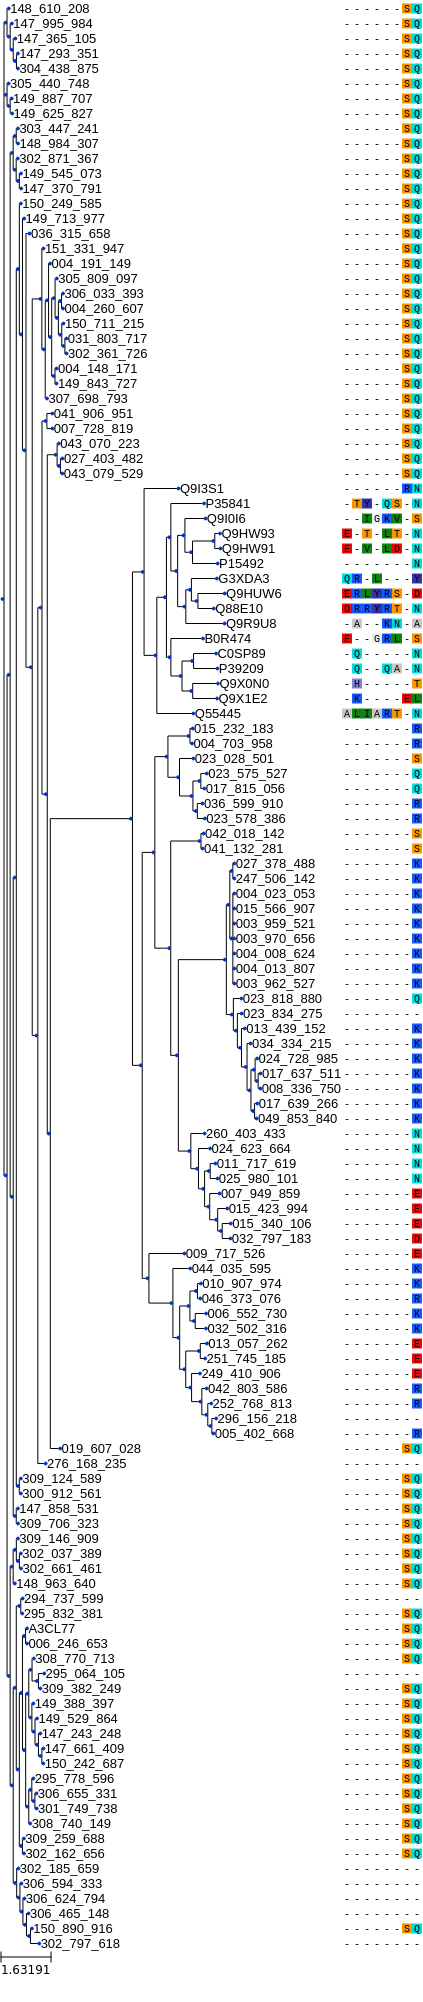

In [9]:
### VISUALIZING THE TREE ###
ts = TreeStyle()
ts.layout_fn = lambda x: True

for leaf in tree.iter_leaves():
    draw_position = 0
    for position in position_matrix:
        seqFace = SeqMotifFace(leaf.sequence[position], seq_format="seq")
        (tree&leaf.name).add_face(seqFace, draw_position, "aligned")
        draw_position += 1

tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

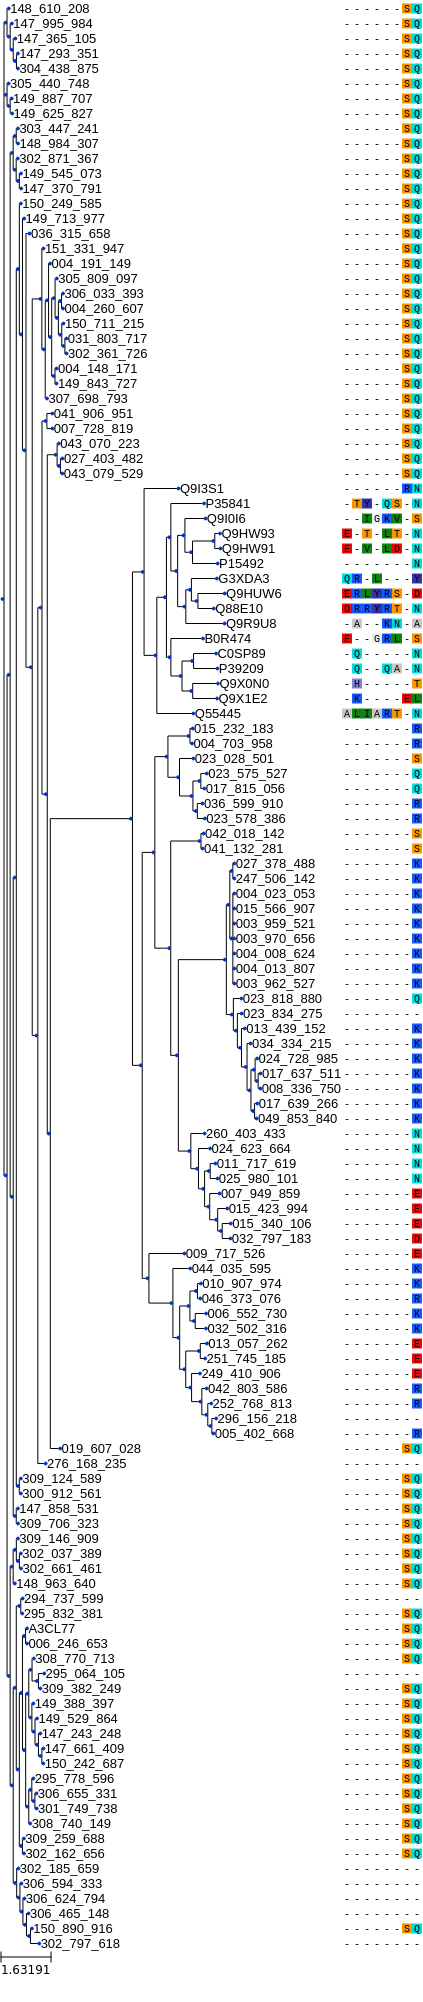

In [9]:
### VISUALIZING THE TREE ###
ts = TreeStyle()
ts.layout_fn = lambda x: True

for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(leaf.sequence[position], seq_format="seq")
            (tree&leaf.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1
    else:
        

tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)